### Full implementation of GP-BO optimization of neurostimulation

@file OptimizeNeurostim.ipynb

@authors Rose Guay-Hottin https://github.com/RoseGH20  
         Marco Bonizzato https://github.com/mbonizzato  
@version 1.0 / June 2021

The code below displays algorithmic performance on provided datasets
for all values of a selected hyperparameter.

Hyperparameter selection is crucial for GP-BO applications. We recommend
running this code on own existing or surrogate data to tune at least the
UCB acquisition function hyperparameter "k" (kappa).

In [9]:
import numpy as np 
import time
from datetime import date
import GPy 
from utils import *

### Select modality

In [10]:
path_to_dataset= 'nhp_data'
dataset='nhp' # selected dataset
which_opt= 'kappa' # hyperparameter to optimize
nRep=30 # number of repetitions
get_running_time(dataset,nRep) # Provide a rough estimation of running time

The procedure can take approximately 8.0 to 13.0 hours on a standard workstation (Intel i7-8700 @ 3.2GHz)


### Variables

In [11]:
mKernel=5 #Matern kernel order

# rho (high, low) is the kernel geometrical hyperparameter (lengthscales)
# kappa is the UCB acquisition function hyperparameter
# nrnd is the number of random queries performed to initialize the GP-BO
# noisemax is the maximum value for the noise hyperparameter

if dataset=='nhp':
    noise_min= 0.009 #Non-zero to avoid numerical instability
    kappa=4.0 
    rho_high=3.0 
    rho_low=0.1
    nrnd=1 #has to be >= 1
    noise_max=0.011
    n_subject=4
    n_Chan=96
    # In this version, datasets are not loaded synchronously,
    # so we here define the total number of EMG and the max number per subject to expect
    tot_emgs=22
    max_emgs=8
    
elif dataset=='rat':
    noise_min=0.0001
    kappa=3.0
    rho_high=5 
    rho_low=0.02
    nrnd=1 #has to be >= 1
    noise_max=0.05
    n_subject=6
    n_Chan=32
    # In this version, datasets are not loaded synchronously,
    # so we here define the total number of EMG and the max number per subject to expect
    tot_emgs=40
    max_emgs=8
    
this_opt= param_grid(which_opt, dataset) # A selection of values to be tested for the selected hyperparameter

# prepare results storage
hyperparams = np.zeros((n_subject,max_emgs,len(this_opt),nRep, n_Chan,4)) # hyperparameters
Stored_MaxSeenResp = np.zeros((n_subject,max_emgs,len(this_opt),nRep, n_Chan)) # maximum recorded response
Stored_perf_explore = np.zeros((n_subject,max_emgs, len(this_opt), nRep, n_Chan)) # exploration score
Stored_perf_exploit = np.zeros((n_subject,max_emgs, len(this_opt), nRep, n_Chan)) # exploitation score
Stored_P_test= np.zeros((n_subject,max_emgs ,len(this_opt),nRep, n_Chan, 2)) # points tested and response
Stored_MappingAccuracyRSQ= np.zeros((n_subject,max_emgs, len(this_opt), nRep)) # R-squared of mapping accuracy
#Stored_YMU= np.zeros((n_subject,max_emgs,len(this_opt),nRep, n_Chan,n_Chan)) # predicted map, as average of GP fitting

Values of kappa to be tested: [ 1.   2.   3.   3.5  3.8  4.1  4.4  4.7  5.   5.5  6.5  7.   8.   9.
 10. ]


### Optimization run

In [ ]:
np.random.seed(0)
# timing estimation utilities
startTime = time.time()
count_perf=0
tot_perf=tot_emgs*len(this_opt)  

for m_i in range(n_subject): # for each subject
    
    subject=load_matlab_data(path_to_dataset,dataset,m_i) # due to memory limitations, each subject is loaded sequentially
    # during the optimization
    
    for k_i in range(len(this_opt)): # for each hyperparameter value
        if which_opt=='nrnd':
            nrnd= this_opt[k_i]
        elif which_opt=='rho_low':
            rho_low= this_opt[k_i]
        elif which_opt=='rho_high':
            rho_high= this_opt[k_i]
        elif which_opt=='noise_min':
            noise_min= this_opt[k_i]
            noise_max= noise_min*1.1
        elif which_opt=='noise_max':
            noise_max= this_opt[k_i]
            noise_min=0.0001
        elif which_opt=='kappa':
            kappa= this_opt[k_i]
            
        for e_i in range(len(subject['emgs'])): # for each muscle of the given subject
         
            # display remaining time information    
            print([m_i, k_i, e_i])
            print(str(count_perf/tot_perf*100)+ ' % completed')
            
            if count_perf>0:
                t=time.time() - startTime
                hs=np.floor((t/count_perf)*(tot_perf-count_perf)/60/60)
                mins=np.floor((t/count_perf)*(tot_perf-count_perf)/60-hs*60)
                print('Estimated remaining time: '+ str(hs)+ ' hours, '+ str(mins)+ ' minutes.')

            # "Ground truth" map
            MPm= subject['sorted_respMean'][:,e_i]
            # Best known channel
            mMPm= np.max(MPm)
        
            # Create the kernel
            # Put a  prior on the two lengthscale hyperparameters and the variance
            matk = GPy.kern.Matern52(input_dim=2,variance=1.0, lengthscale=[1.0, 1.0], ARD=True, name='Mat52') 
            matk.variance.set_prior(GPy.priors.Uniform(0.01**2,100**2), warning=False)
            matk.lengthscale.set_prior(GPy.priors.Uniform(rho_low, rho_high), warning=False)
            
            # Then run the sequential optimization
            DimSearchSpace = subject['nChan']
            MaxQueries = DimSearchSpace
            perf_explore= np.zeros((nRep, DimSearchSpace))
            perf_exploit= np.zeros((nRep, DimSearchSpace))
            MappingAccuracyRSQ= np.zeros((nRep))
            P_test =  np.zeros((nRep, DimSearchSpace, 2)) #storing all queries
            
            for rep_i in range(nRep): # for each repetition
                # maximum response obtained in this round, used to normalize all responses between zero and one.                
                MaxSeenResp=0 
                q=0 # query number                                
                hyp=[1.0, 1.0, 1.0, 1.0]  # initialize kernel hyperparameters               
                order_this= np.random.permutation(DimSearchSpace) # random permutation of each entry of the search space
                P_max=[] 
            
                while q < MaxQueries:
                    # We will sample the search space randomly for exactly nrnd queries
                    if q>=nrnd:
                        # Find next point (max of acquisition function)
                        AcquisitionMap = ymu + kappa*np.nan_to_num(np.sqrt(ys2)) # UCB acquisition
                        NextQuery= np.where(AcquisitionMap.reshape(len(AcquisitionMap))==np.max(AcquisitionMap.reshape(len(AcquisitionMap))))
                        # select next query
                        if len(NextQuery) > 1:
                            NextQuery = NextQuery[np.random.randint(len(NextQuery))]    
                        else:   
                            NextQuery = NextQuery[0]
                        P_test[rep_i][q][0]= NextQuery[0]
                    else:
                        P_test[rep_i][q][0]= int(order_this[q]) 
                    query_elec = P_test[rep_i][q][0]
                    
                    # This offline optimization code randomly choses one
                    # response among all responses stored in the
                    # selected search space look-up table.
                    valid_resp= subject['sorted_resp'][int(query_elec)][e_i][subject['sorted_isvalid'][int(query_elec)][e_i]!=0]
                    r_i= np.random.randint(len(valid_resp)) 
                    test_respo= valid_resp[r_i]
                    # done reading response
                    P_test[rep_i][q][1]= test_respo
                    # The first element of P_test is the selected search
                    # space point, the second the resulting value
                        
                    if (test_respo > MaxSeenResp) or (MaxSeenResp==0):
                        # updated maximum response obtained in this round
                        MaxSeenResp=test_respo                           
                        
                    x= subject['ch2xy'][P_test[rep_i][:q+1,0].astype(int),:] # search space position
                    y= P_test[rep_i][:q+1,1]/MaxSeenResp # test result 
                    y= y.reshape((len(y),1))
                
                    # Update the initial value of the parameters  
                    matk.variance= hyp[2]
                    matk.lengthscale[0]= hyp[0]
                    matk.lengthscale[1]= hyp[1]
                        
                    # Initialization of the model and the constraint of the Gaussian noise 
                    if q==0:
                        m=GPy.models.GPRegression(x,y, kernel= matk, normalizer=None, noise_var=hyp[3])
                        m.Gaussian_noise.constrain_bounded(noise_min**2,noise_max**2, warning=False)
                    else:
                        m.set_XY(x,y)
                        m.Gaussian_noise.variance[0]=hyp[3]
                    
                    # GP-BO optimization
                    m.optimize(optimizer='scg', start= None, messages=False, max_iters=10, ipython_notebook=True,
                               clear_after_finish=True)

                    X_test= subject['ch2xy']
                    ymu, ys2= m.predict(X_test, full_cov=False, Y_metadata=None, include_likelihood=True)
                    
                    # We only test for gp predictions at electrodes that
                    # we had queried (presumable we only want to return an
                    # electrode that we have already queried). 
                    Tested= np.unique(P_test[rep_i][:q+1,0].astype(int))
                    MapPredictionTested=ymu[Tested]
                    BestQuery= Tested[(MapPredictionTested==np.max(MapPredictionTested)).reshape(len(MapPredictionTested))]
                    
                    if len(BestQuery) > 1:
                        BestQuery = np.array([BestQuery[np.random.randint(len(BestQuery))]])
                    # Maximum response at time q           
                    P_max.append(BestQuery[0])
                    # store all info
                    Stored_MaxSeenResp[m_i,e_i,k_i,rep_i,q] = MaxSeenResp
                    hyp= [m.Mat52.lengthscale[0], m.Mat52.lengthscale[1], m.Mat52.variance[0], m.Gaussian_noise.variance[0]] 
                    hyperparams[m_i,e_i,k_i,rep_i,q,:] = hyp
                    #Stored_YMU[m_i,e_i,k_i,rep_i,q,:]=ymu.reshape(len(ymu))
                    q+=1
                
                # estimate current exploration performance: knowledge of best stimulation point
                perf_explore[rep_i,:]=MPm[P_max].reshape((len(MPm[P_max])))/mMPm 
                # estimate current exploitation performance: knowledge of best stimulation point
                perf_exploit[rep_i,:]= P_test[rep_i][:,0].astype(int) 
                # calculate model fitting of ground truth value map
                mdl= np.corrcoef(MPm, ymu.reshape(ymu.shape[0]))[0,1]
                MappingAccuracyRSQ[rep_i]=mdl**2
                # store all tests
                Stored_P_test[m_i,e_i,k_i,rep_i,:]=P_test[rep_i]
            
            # store all performance estimations
            Stored_MappingAccuracyRSQ[m_i,e_i,k_i]=MappingAccuracyRSQ
            Stored_perf_explore[m_i,e_i,k_i]=perf_explore
            Stored_perf_exploit[m_i,e_i,k_i]= MPm[perf_exploit.astype(int)]/mMPm;
            count_perf+=1
            
# Saving variables                        
np.savez(dataset+'_'+which_opt+'_'+str(nRep)+'_'+date.today().strftime("%y%m%d")+'.npz',
         Stored_MaxSeenResp=Stored_MaxSeenResp, hyperparams=hyperparams, Stored_P_test=Stored_P_test,
         Stored_perf_explore=Stored_perf_explore, Stored_perf_exploit=Stored_perf_exploit,
         Stored_MappingAccuracyRSQ=Stored_MappingAccuracyRSQ, this_opt=this_opt)

### Show performance graphs

In [ ]:
data = np.load('optim_nhp/nhp_kappa_30_210623.npz')
Stored_perf_explore= data['PP']
Stored_perf_exploit= data['PP_t']
this_opt=data['this_opt']
which_opt='kappa'
dataset='nhp'

Exploration: [0.63394186 0.78269383 0.85343074 0.87485223 0.86396991 0.87652955
 0.87925284 0.86566462 0.86019433 0.84691641 0.83597545 0.81350191
 0.79540308 0.77167873 0.77930074]
Exploitation: [0.63303932 0.78088927 0.84895501 0.87283269 0.8610674  0.86537894
 0.86181484 0.84406736 0.84721737 0.80207004 0.73142812 0.67186308
 0.5849582  0.4737551  0.36410565]


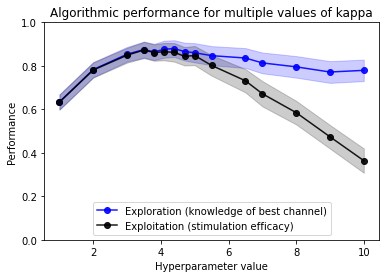

In [4]:
plot_optim_results(Stored_perf_explore,Stored_perf_exploit,which_opt, this_opt, dataset)